In [91]:
! pip install medmnist

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from medmnist import OCTMNIST

In [107]:
# Data loading and preprocessing
train = OCTMNIST(split='train', download=True)
val = OCTMNIST(split='val', download=True)



Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [108]:
X, y = train.imgs / 255.0, train.labels
X_val, y_val = val.imgs / 255.0, val.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

In [109]:
class SynapticIntelligence:
    def __init__(self, model):
        self.model = model
        self.omega = [tf.zeros_like(weight) for weight in model.trainable_weights]
        self.init_weights = [tf.identity(weight) for weight in model.trainable_weights]
        self.importance_accumulation = [tf.zeros_like(weight) for weight in model.trainable_weights]
    
    def update_importance(self, gradients):
        for i, grad in enumerate(gradients):
            self.importance_accumulation[i] += tf.square(grad)
    
    def consolidate(self):
        for i, weight in enumerate(self.model.trainable_weights):
            self.omega[i] += self.importance_accumulation[i] / (tf.square(weight - self.init_weights[i]) + 1e-7)
            self.importance_accumulation[i] = tf.zeros_like(weight)
            self.init_weights[i] = tf.identity(weight)
    
    def regularization_loss(self):
        loss = 0
        for omega, init_weight, current_weight in zip(self.omega, self.init_weights, self.model.trainable_weights):
            loss += tf.reduce_sum(omega * tf.square(current_weight - init_weight))
        return loss


In [110]:
def create_model(num_classes, input_shape=(28,28,1)):
    model = Sequential([
        Conv2D(25, (4,4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(111, (4,4), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(123, (4,4), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(102, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0007008969316805274),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [111]:
# def train_task_with_si(model, si, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, si_lambda=0.1):
#     optimizer = Adam(learning_rate=0.0001)
#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{epochs}")
#         for batch in range(0, len(X_train), batch_size):
#             X_batch = X_train[batch:batch+batch_size]
#             y_batch = y_train[batch:batch+batch_size]
#             with tf.GradientTape() as tape:
#                 preds = model(X_batch, training=True)
#                 task_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds))
#                 reg_loss = si_lambda * si.regularization_loss()
#                 total_loss = task_loss + reg_loss
#             gradients = tape.gradient(total_loss, model.trainable_weights)
#             si.update_importance(gradients)
#             optimizer.apply_gradients(zip(gradients, model.trainable_weights))
# #             print("training............")
#         val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
#         print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
#     si.consolidate()



In [122]:
import numpy as np

# Generate noisy samples (assuming this function already exists)
def generate_noisy_samples(num_samples, input_shape):
    return np.random.rand(num_samples, *input_shape)

# Define the shape of your input data
input_shape = (28, 28, 1)

# Number of noisy samples to add
num_noisy_samples = 10000  # Adjust this number as needed

# Generate noisy samples
noisy_samples = generate_noisy_samples(num_noisy_samples, input_shape)

# Create labels for the noisy samples (e.g., 50 labeled as 0 and 50 as 1)
noisy_labels_0 = np.zeros(num_noisy_samples // 2)  # First half as class 0
noisy_labels_1 = np.ones(num_noisy_samples // 2)   # Second half as class 1

# Combine the labels
noisy_labels = np.concatenate([noisy_labels_0, noisy_labels_1])

# Shuffle the noisy samples and labels together
shuffled_indices = np.random.permutation(num_noisy_samples)
noisy_samples = noisy_samples[shuffled_indices]
noisy_labels = noisy_labels[shuffled_indices]

y_train_task = y_train_task.reshape(-1)  # Ensures it's 1D

# Now, add these noisy samples to the original training set
X_train_augmented = np.concatenate([X_train_task, noisy_samples], axis=0)
y_train_augmented = np.concatenate([y_train_task, noisy_labels], axis=0)

# Check shapes of augmented data
print(f"Shape of augmented X_train: {X_train_augmented.shape}")  # Should be (35097, 28, 28, 1)
print(f"Shape of augmented y_train: {y_train_augmented.shape}")  # Should be (35097,)



Shape of augmented X_train: (45107, 28, 28, 1)
Shape of augmented y_train: (45107,)


In [123]:
from tqdm import tqdm

def train_task_with_si(model, si, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, si_lambda=0.1):
    optimizer = Adam(learning_rate=0.0001)
    
    # Initialize history lists
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        with tqdm(total=len(X_train) // batch_size, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch in range(0, len(X_train), batch_size):
                X_batch = X_train[batch:batch+batch_size]
                y_batch = y_train[batch:batch+batch_size]
                with tf.GradientTape() as tape:
                    preds = model(X_batch, training=True)
                    task_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds))
                    reg_loss = si_lambda * si.regularization_loss()
                    total_loss = task_loss + reg_loss
                gradients = tape.gradient(total_loss, model.trainable_weights)
                si.update_importance(gradients)
                optimizer.apply_gradients(zip(gradients, model.trainable_weights))
                
                pbar.update(1)
        
        # Evaluate on the validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        
        # Store the metrics in history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    si.consolidate()
    return history


In [124]:

# # Filter data for classes and evaluate each task
# def filter_data(X, y, classes):
#     mask = np.isin(y, classes)
#     return X[mask], y[mask]

def filter_data(X, y, classes):
    mask = np.isin(y, classes).flatten()
    return X[mask], y[mask]

In [125]:

def evaluate(model, X_test, y_test, task_num):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"\nTask {task_num} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))

In [126]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [127]:
# Initial model training on classes 0 and 1
num_classes = 2
model = create_model(num_classes)
si = SynapticIntelligence(model)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
# Prepare data for classes 0 and 1
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1])
X_train_task, y_train_task= X_train_augmented,y_train_augmented



Training on initial Task (Classes 0 and 1)
Epoch 1/5


Training Epoch 1/5: 1410batch [03:04,  7.66batch/s]                       


Training Loss: 3.0334, Training Accuracy: 0.7285
Validation Loss: 3.7016, Validation Accuracy: 0.7661
Epoch 2/5


Training Epoch 2/5: 1410batch [03:04,  7.65batch/s]                       


Training Loss: 5.9687, Training Accuracy: 0.7194
Validation Loss: 7.3413, Validation Accuracy: 0.7397
Epoch 3/5


Training Epoch 3/5: 1410batch [03:03,  7.68batch/s]                       


Training Loss: 9.0988, Training Accuracy: 0.7539
Validation Loss: 11.4882, Validation Accuracy: 0.7663
Epoch 4/5


Training Epoch 4/5: 1410batch [03:04,  7.63batch/s]                       


Training Loss: 5.4211, Training Accuracy: 0.7597
Validation Loss: 6.6722, Validation Accuracy: 0.7652
Epoch 5/5


Training Epoch 5/5: 1410batch [03:02,  7.71batch/s]                       


Training Loss: 10.3684, Training Accuracy: 0.7606
Validation Loss: 13.2162, Validation Accuracy: 0.7663
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      1.00      0.87      6655
     Class 1       0.00      0.00      0.00      2045

    accuracy                           0.76      8700
   macro avg       0.38      0.50      0.43      8700
weighted avg       0.59      0.76      0.66      8700



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


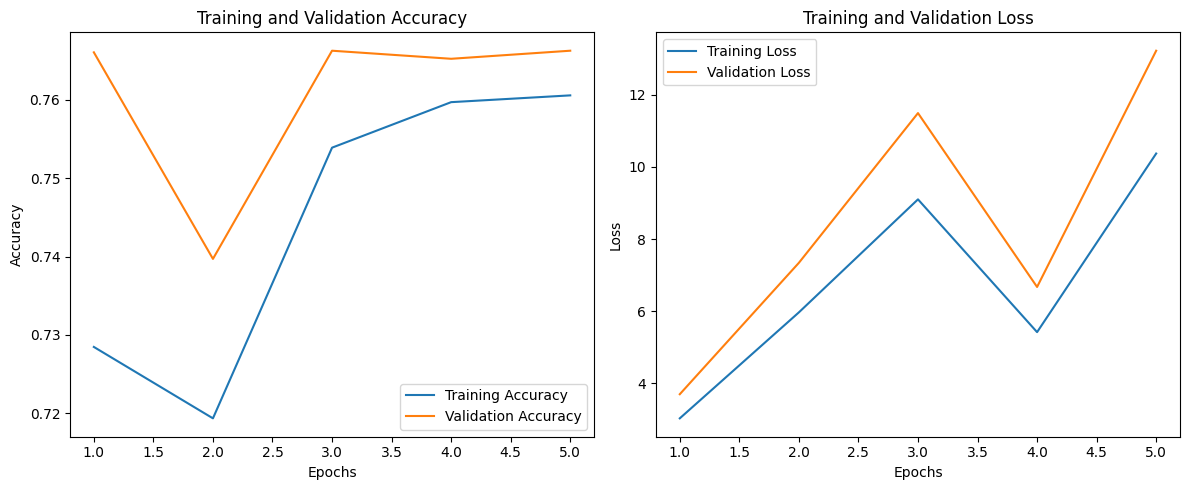

In [129]:
print("Training on initial Task (Classes 0 and 1)")
history_01 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1]), task_num=1)

plot_training_history(history_01)


In [33]:
# Consolidate knowledge on classes 0 and 1
si.consolidate()

In [34]:
# Extend model to handle classes 0, 1, and 2
num_classes = 3
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Prepare data for classes 0, 1, and 2
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2])



Training on Task with Classes 0, 1, and 2
Epoch 1/5


Training Epoch 1/5: 1288batch [02:47,  7.70batch/s]                       


Training Loss: 0.4563, Training Accuracy: 0.8172
Validation Loss: 0.4580, Validation Accuracy: 0.8176
Epoch 2/5


Training Epoch 2/5: 1288batch [02:44,  7.81batch/s]                       


Training Loss: 0.4048, Training Accuracy: 0.8401
Validation Loss: 0.4123, Validation Accuracy: 0.8356
Epoch 3/5


Training Epoch 3/5: 1288batch [02:44,  7.82batch/s]                       


Training Loss: 0.3437, Training Accuracy: 0.8635
Validation Loss: 0.3579, Validation Accuracy: 0.8599
Epoch 4/5


Training Epoch 4/5: 1288batch [02:46,  7.76batch/s]                       


Training Loss: 0.3240, Training Accuracy: 0.8698
Validation Loss: 0.3468, Validation Accuracy: 0.8597
Epoch 5/5


Training Epoch 5/5: 1288batch [02:46,  7.76batch/s]                       


Training Loss: 0.2680, Training Accuracy: 0.8984
Validation Loss: 0.3075, Validation Accuracy: 0.8841
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.93      6655
     Class 1       0.81      0.84      0.83      2045
     Class 2       0.75      0.67      0.71      1541

    accuracy                           0.87     10241
   macro avg       0.83      0.81      0.82     10241
weighted avg       0.87      0.87      0.87     10241



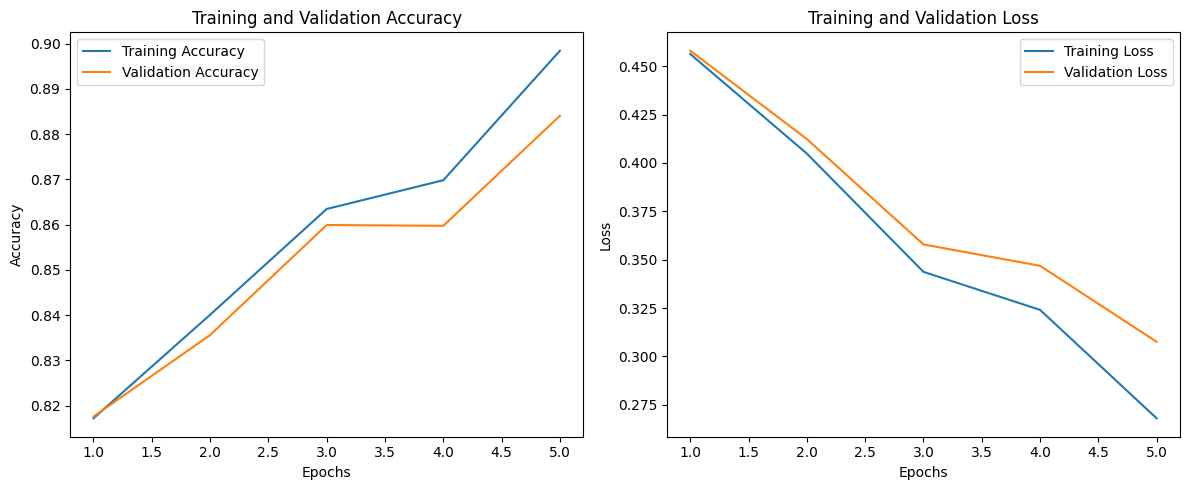

In [36]:
print("\nTraining on Task with Classes 0, 1, and 2")
history_012 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2]), task_num=1)

plot_training_history(history_012)


In [37]:
# Consolidate knowledge on classes 0, 1, and 2
si.consolidate()

In [38]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 4
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3])


Training on Task with Classes 0, 1, 2, and 3
Epoch 1/5


Training Epoch 1/5: 2437batch [05:12,  7.80batch/s]                       


Training Loss: 0.6129, Training Accuracy: 0.8033
Validation Loss: 0.6119, Validation Accuracy: 0.8047
Epoch 2/5


Training Epoch 2/5: 2437batch [05:17,  7.68batch/s]                       


Training Loss: 0.4724, Training Accuracy: 0.8389
Validation Loss: 0.4835, Validation Accuracy: 0.8378
Epoch 3/5


Training Epoch 3/5: 2437batch [05:18,  7.65batch/s]                       


Training Loss: 0.4425, Training Accuracy: 0.8509
Validation Loss: 0.4678, Validation Accuracy: 0.8472
Epoch 4/5


Training Epoch 4/5: 2437batch [05:16,  7.71batch/s]                       


Training Loss: 0.5183, Training Accuracy: 0.8419
Validation Loss: 0.5627, Validation Accuracy: 0.8347
Epoch 5/5


Training Epoch 5/5: 2437batch [05:17,  7.67batch/s]                       


Training Loss: 0.3924, Training Accuracy: 0.8698
Validation Loss: 0.4502, Validation Accuracy: 0.8567
610/610 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.89      0.91      6655
     Class 1       0.86      0.67      0.75      2045
     Class 2       0.61      0.17      0.27      1541
     Class 3       0.82      0.99      0.90      9255

    accuracy                           0.86     19496
   macro avg       0.81      0.68      0.71     19496
weighted avg       0.85      0.86      0.84     19496



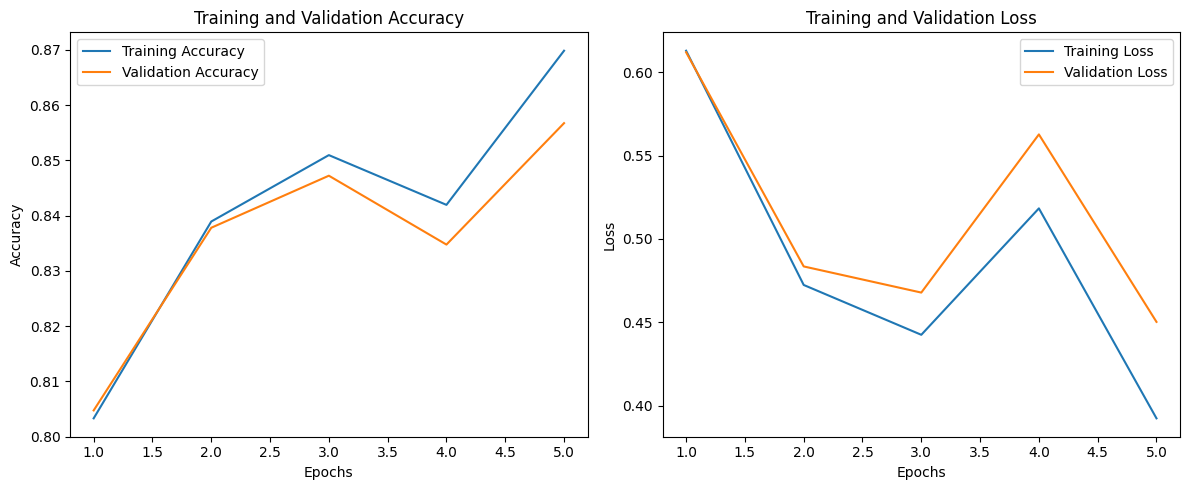

In [40]:
print("\nTraining on Task with Classes 0, 1, 2, and 3")
history_0123 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2, 3]), task_num=1)

plot_training_history(history_0123)

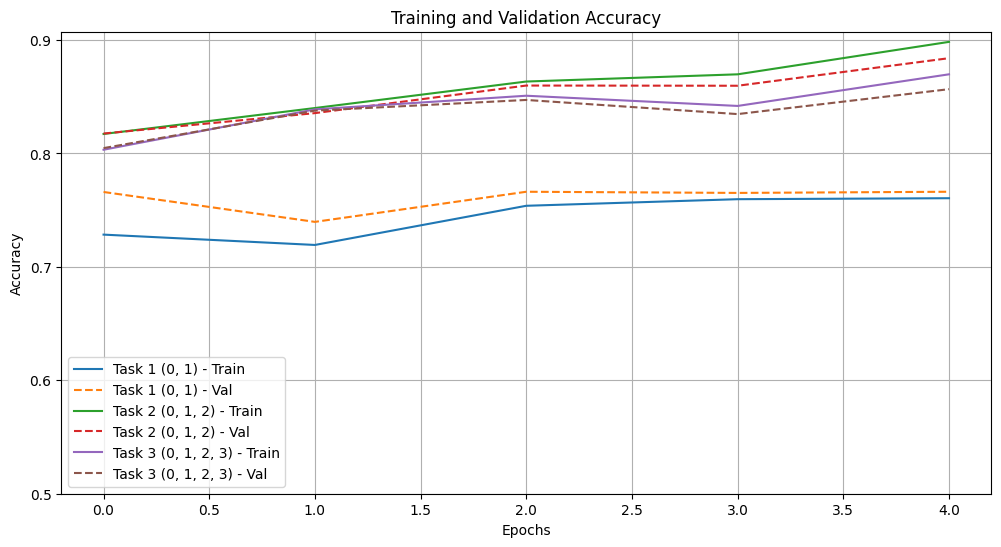

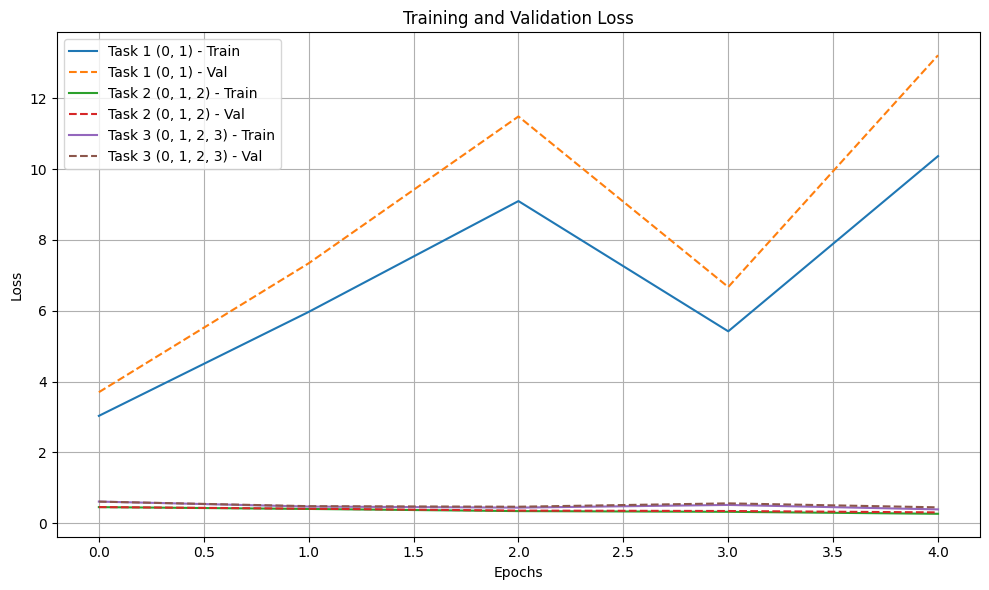

In [131]:
import matplotlib.pyplot as plt

def plot_task_accuracies(histories, task_labels):
    plt.figure(figsize=(12, 6))

    # Plotting Accuracy
#     plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['train_accuracy'], label=f'Task {task_labels[i]} - Train')
        plt.plot(history['val_accuracy'], label=f'Task {task_labels[i]} - Val', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.5,1,0.1))
    plt.legend()
    plt.grid()
    
    
def plot_task_losses(histories,task_labels):
    # Plotting Loss
#     plt.subplot(1, 2, 2)
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(histories):
        plt.plot(history['train_loss'], label=f'Task {task_labels[i]} - Train')
        plt.plot(history['val_loss'], label=f'Task {task_labels[i]} - Val', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
#     plt.yticks(np.arange(0,0.8,0.1))
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# Collect the histories for each task
task_histories = [history_01, history_012, history_0123]
task_labels = ['1 (0, 1)', '2 (0, 1, 2)', '3 (0, 1, 2, 3)']

# Call the plotting function
plot_task_accuracies(task_histories, task_labels)
plot_task_losses(task_histories, task_labels)



In [22]:
histories = []

In [24]:
# Extend model for additional classes and train with SI

for new_class in [2, 3]:
    num_classes += 1
    old_weights = model.get_weights() 
    model = create_model(num_classes)
    model.set_weights(old_weights[:len(model.layers) - 1])

#     model.set_weights(model.get_weights()[:len(si.init_weights)])  # Transfer previous weights
    si = SynapticIntelligence(model)  # Reinitialize SI with new output layer

    # Train on the extended task
    task_classes = list(range(num_classes))
    X_train_task, y_train_task = filter_data(X_train, y_train, task_classes)
    X_val_task, y_val_task = filter_data(X_val, y_val, task_classes)
    print(f"\nTraining on Task {new_class-1} (Classes {task_classes})")
    temp_history = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task)
    histories.append(temp_history)
    # Evaluate the model after training on each new task
    X_test_task, y_test_task = filter_data(X_test, y_test, task_classes)
    evaluate(model, X_test_task, y_test_task, task_num=new_class-1)
    plot(temp_history.history)

ValueError: You called `set_weights(weights)` on layer 'sequential_5' with a weight list of length 11, but the layer was expecting 22 weights.